## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [4]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.sparse import hstack


In [5]:
df = pd.read_csv("train.csv")

In [6]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [8]:
df.is_duplicate.unique()

array([0, 1])

In [9]:
df[df.is_duplicate==1]

,id,qid1,qid2,question1,question2,is_duplicate
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
11,11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
12,12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1
13,13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1
...,...,...,...,...,...,...
404280,404280,537922,537923,What are some outfit ideas to wear to a frat p...,What are some outfit ideas wear to a frat them...,1
404281,404281,99131,81495,Why is Manaphy childish in Pokémon Ranger and ...,Why is Manaphy annoying in Pokemon ranger and ...,1
404282,404282,1931,16773,How does a long distance relationship work?,How are long distance relationships maintained?,1
404284,404284,537926,537927,What does Jainism say about homosexuality?,What does Jainism say about Gays and Homosexua...,1


In [10]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [11]:
df[df['question2'].isnull()]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


In [12]:
df[df['question1'].isnull()]

,id,qid1,qid2,question1,question2,is_duplicate
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [13]:
data=df.fillna("")


In [14]:
data.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [15]:
data.shape

(404290, 6)

### Exploration

is_duplicate
0    255027
1    149263
Name: id, dtype: int64

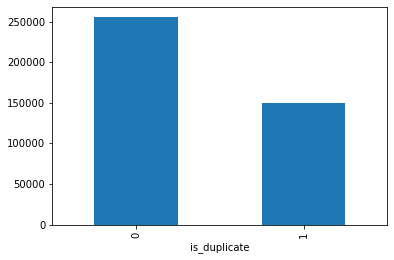

In [73]:
#imbalanced dataset?
data.groupby("is_duplicate")['id'].count().plot.bar()
data.groupby("is_duplicate")['id'].count()

In [16]:
#unbalanced dataset:
dup = df[df['is_duplicate'] == 1]
not_dup = df[df['is_duplicate'] == 0].sample(149263)

In [17]:
df_balanced=pd.concat([dup,not_dup],ignore_index=True)

<AxesSubplot:xlabel='is_duplicate'>

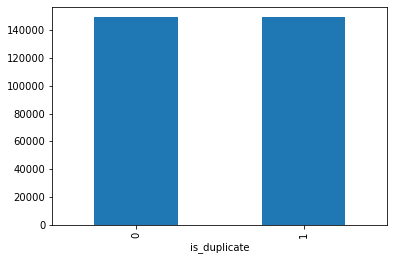

In [18]:

df_balanced.groupby("is_duplicate")['id'].count().plot.bar()

In [19]:
#now the dataset is balanced
df_balanced.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
1,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
2,11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
3,12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1
4,13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1


In [20]:
#shuffle the dataset
df_balanced=df_balanced.sample(frac=1)

In [21]:
df_balanced.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
15,50,101,102,Is Career Launcher good for RBI Grade B prepar...,How is career launcher online program for RBI ...,1
3784,10197,19788,10896,What will happen to the money in foreign banks...,What will happen to corruption money deposited...,1
261568,128335,206419,206420,What is the work that is assigned to a GIS pro...,What are the designations that a GIS Wipro pro...,0
23336,62517,108946,108947,What successful American companies or startups...,What successful American companies or startups...,1
56382,151403,238060,238061,Is Baluchistan an independent country or region?,Is Baluchistan is going to be an independent c...,1
112629,303010,199334,229800,Will China become a democracy?,Will China ever become a true democracy?,1
219273,82388,139708,139709,Are we alone in the universe?,What if we are all alone in the Universe?,0
22428,60099,4734,7332,What are the best programming languages to lea...,What is the best programming language I should...,1
295037,347272,475731,475732,What should you not feed squirrels?,What should you feed a squirrel?,0
183485,118435,192484,192485,If your spouse and baby were drowning but coul...,"If there was a fire, and only one could be sav...",0


#### split training and testing

In [22]:
traing_df=df_balanced.sample(frac=0.8)
testing_df=df_balanced.sample(frac=0.2)

<AxesSubplot:xlabel='is_duplicate'>

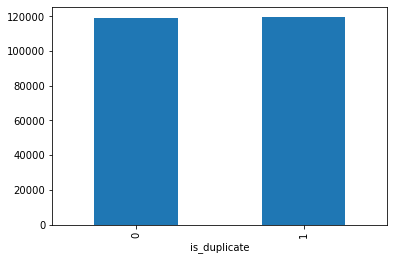

In [23]:
traing_df.groupby("is_duplicate")['id'].count().plot.bar()

In [24]:
traing_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238821 entries, 174951 to 225481
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            238821 non-null  int64 
 1   qid1          238821 non-null  int64 
 2   qid2          238821 non-null  int64 
 3   question1     238821 non-null  object
 4   question2     238820 non-null  object
 5   is_duplicate  238821 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 12.8+ MB


In [48]:
x=traing_df[['question1','question2']]

In [77]:
for index, row in x.iterrows():
    if index >1000 and index <=1050:
        
        print(row['question1'])
        print(row['question2'])
        print()

What are the safety precautions on handling shotguns proposed by the NRA in Minnesota?
What are the safety precautions on handling shotguns proposed by the NRA in Rhode Island?

How do I clear IBPS PO in one month?
How do I prepare IBPS PO exam in one month?

How do people randomly find me on instagram?
How do people find me on instagram?

What is the reason behind having one small testicle and b=one bigger comparatively?
What is the reason behind having one small testicle and other is bigger comparatively?

What really happened at MG Road, Bangalore on New Year’s Eve 2017?
What exactly happened on 2017 New Year's Eve in Bengaluru? What could be causes of this?

Is iPhone 5s compatible for Jio VoLTE app?
Is I phone 5s 4G volte supported?

When you write a rhetorical question, do you follow it with a question mark or a period?
Punctuation: Is it correct to add a question mark after a rhetorical question?

Can skipping increase your height?
How do I increase the height?

How do I turn so

(-0.5, 1439.5, 1079.5, -0.5)

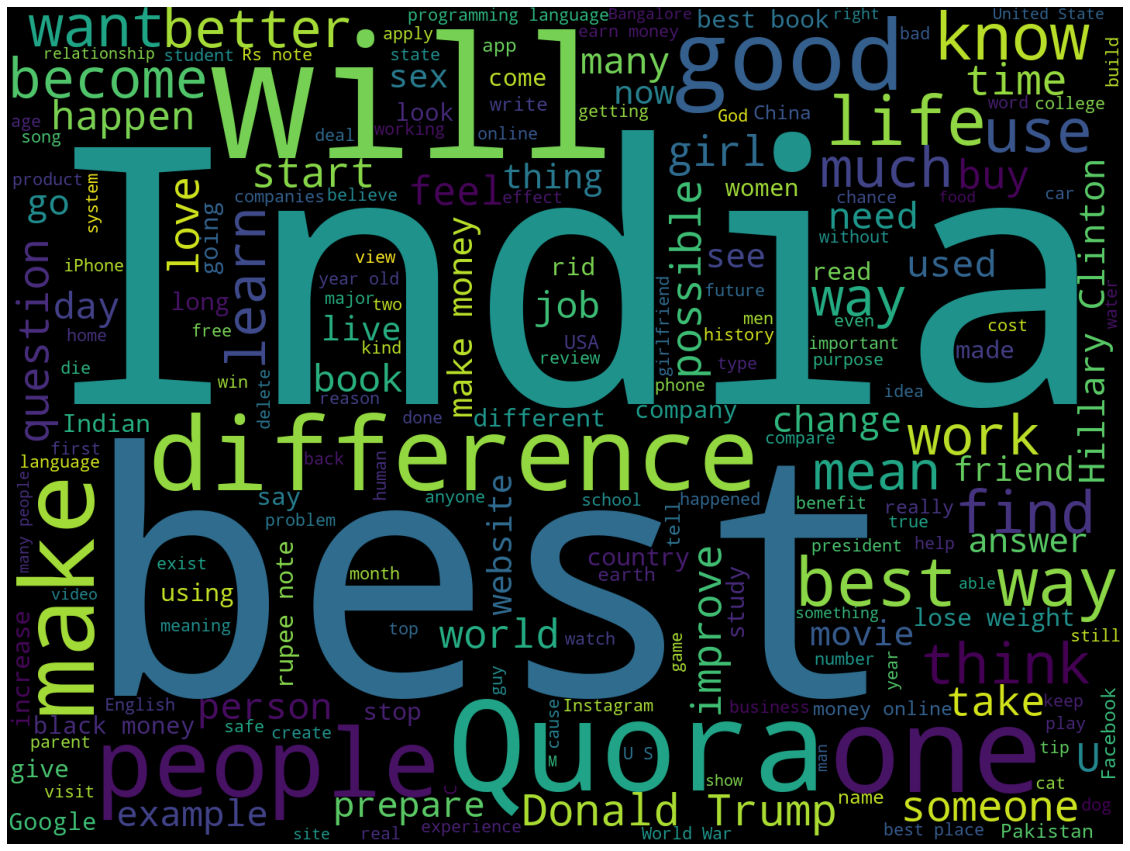

In [25]:
from wordcloud import WordCloud
cloud=WordCloud(width=1440, height = 1080).generate(" ".join(train_question.astype(str)))
plt.figure(figsize=(20,20))

plt.imshow(cloud)
plt.axis('off')

#### Some Statistical info of the dataset as a whole

In [79]:
len(np.unique(train_question))

326899

In [80]:
train_question

0                                                                         How can I become a race car or F1 driver?
1                                                                             How do I transfer to another college?
2                                                                                 Will coconut oil fade hair color?
3                                   How do I reset my Gmail password when I don't remember my recovery information?
4                                                                What are some good photo editing apps for Android?
                                                            ...                                                    
477637    What will the people who have Black Money in Swiss Bank do after the demonetisation of ₹1000 & ₹500 note?
477638                                                             How can I deal with unbearable menstrual cramps?
477639                                                     Why isn't any

In [81]:
print('Question pairs for training: {}'.format(len(train)))
print('Duplicate pairs: {}%'.format(round(train['is_duplicate'].mean()*100, 2)))
print('Total number of unique questions: {}'.format(len(np.unique(train_question))))
print('Questions appear multiple times: {}'.format(np.sum(train_question.value_counts() > 1)))
max(train_question.value_counts())

Question pairs for training: 238821
Duplicate pairs: 49.92%
Total number of unique questions: 326899
Questions appear multiple times: 61212


84

In [82]:
61555/(238821*2)

0.12887267032631133

* The training dataset has 238821 pairs of questions
* There are 326365 unique questions
* 61296 questions appear multiple times
* a question max apear 92 times

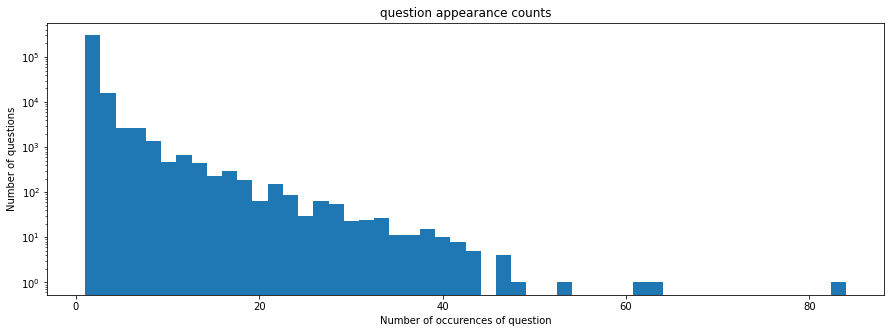

In [83]:

plt.figure(figsize=(15, 5))
plt.hist(train_question.value_counts(), bins=50)
plt.yscale('log')
plt.title('question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

In [84]:
np.sum(train_question.value_counts()>1)

61212

In [85]:
traing_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
26032,69897,120561,62433,How can I become a race car or F1 driver?,What does it take to become a professional F1 driver?,1
25839,69351,119681,119682,How do I transfer to another college?,How can one transfer to another college?,1
178619,195285,295688,229122,Will coconut oil fade hair color?,Is it good to apply coconut oil to hair?,0
78091,209902,10024,61676,How do I reset my Gmail password when I don't remember my recovery information?,How do I reset my password to Gmail without my recovery information?,1
76105,204368,155182,8025,What are some good photo editing apps for Android?,Which is the best photo editing app for android?,1


In [86]:
#Train-question characters analysis
dist_train=train_question.apply(len)

Text(0.5, 0, 'Number of characters')

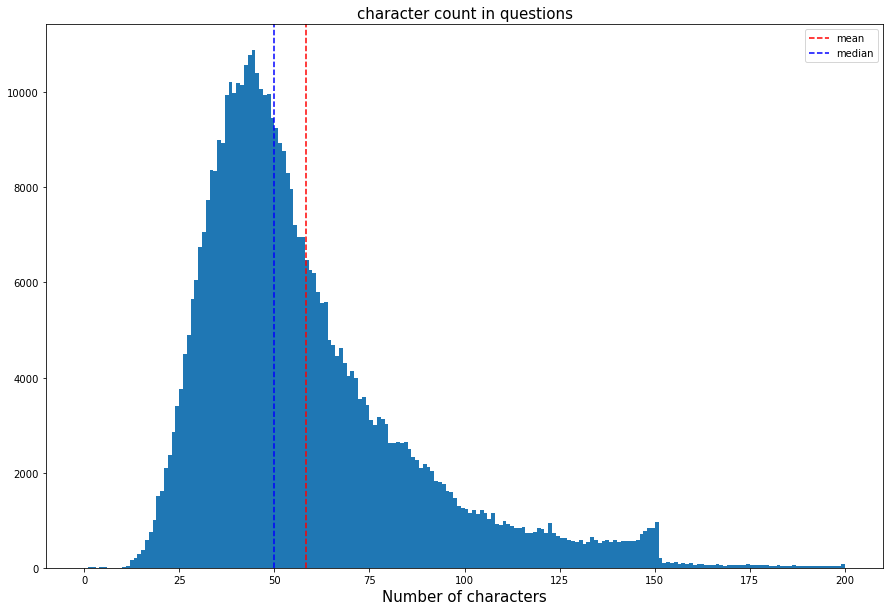

In [87]:
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=200, range=[0, 200])
plt.axvline(dist_train.mean(),color='red',ls='--',label='mean')
plt.axvline(dist_train.median(),color='blue',ls='--',label='median')
plt.title('character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)


In [88]:
#word analysis
word_dist=train_question.apply(lambda x: len(x.split(' ')))

Text(0.5, 0, 'Number of words')

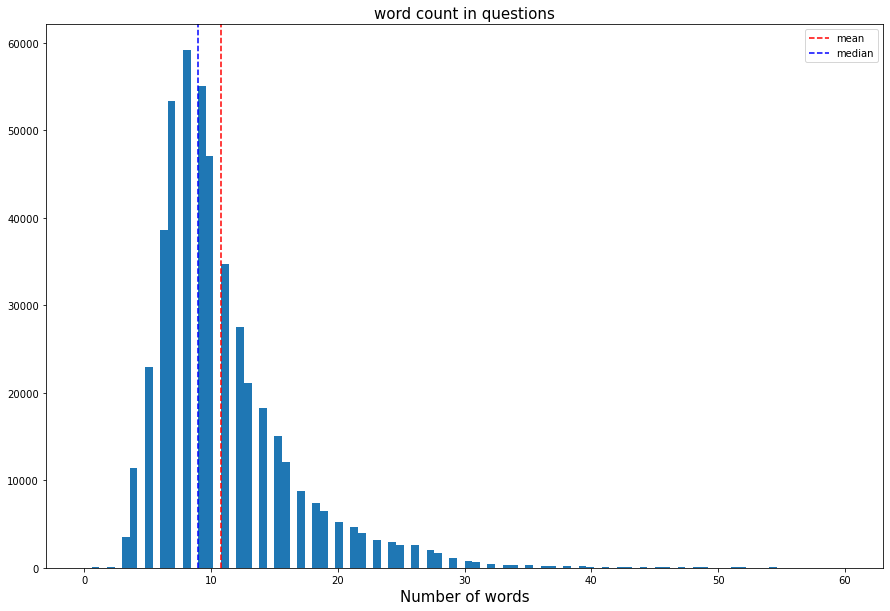

In [89]:
plt.figure(figsize=(15, 10))
plt.hist(word_dist, bins=100, range=[0, 60])
plt.axvline(word_dist.mean(),color='red',ls='--',label='mean')
plt.axvline(word_dist.median(),color='blue',ls='--',label='median')
plt.title('word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)


### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [25]:
# # traing_df.drop(['id', 'qid1', 'qid2'], axis=1)
# a = 0 
# for i in range(a,a+10):
#     print(traing_df.question1[i])
#     print(traing_df.question2[i])
#     print()

In [26]:
question_words = ['Who', 'What', 'Where', 'How', "Whicn" 'When', 'Can', 'Is']


In [27]:
from nltk.corpus import stopwords
import re
import string
from nltk.stem import WordNetLemmatizer


In [28]:
train = traing_df.copy()

In [29]:
train_question=pd.Series(train['question1'].tolist()+ train['question2'].tolist()).astype(str)
test_question=pd.Series(testing_df['question1'].tolist()+ testing_df['question2'].tolist()).astype(str)

In [30]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [31]:
re.sub("\'s", "", "What's") 

'What'

In [32]:
re.sub(r"what's", "", "what's", flags=re.IGNORECASE)

''

In [33]:
def sepcial_char(text):
    #What's --> what
    text=str(text)
    text = re.sub("\'s", "", text)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("whre", " where ", text)
    text = re.sub("can't", "can not", text)
    text = re.sub("n't", " not ", text)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?United State(s)?", " America ", text, flags=re.IGNORECASE)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)

    # remove comma between numbers, i.e. 15,000 -> 15000
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    #remove punctuation
    text = re.sub(r'[^\w\s]', ' ',text)
    
    
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)
    
    
    text = ''.join([t for t in text if t not in string.punctuation]).lower()
    return text

        
# sepcial_char(train['question1'][0])        


In [34]:
train['Q1'] = train['question1'].apply(lambda x: sepcial_char(x))

In [35]:
train['Q2'] = train['question2'].apply(lambda x:sepcial_char(x))

In [36]:
for index, row in train.iterrows():
    if index >1000 and index <=1050:
        
        print(row['Q1'])
        print(row['Q2'])
        print()

does lipton green tea assist in weight loss 
how green tea is useful for reducing fat 

how can i promote udemy course 
what are the best ways to promote udemy courses 

what is our purpose in being here 
what is the purpose of existance 

why is cricket not popular in us even though it was a british colony 
why is cricket not popular in the us despite being a part of former british colonies 

is coaching necessary for cracking the gate 
is it necessary to go for coaching for gate preparation 

how do you control your anger 
how do i control my emotions and anger 

how should a teacher maintain discipline in the classroom 
how can a teacher maintain discipline 

how do i travel for cheap 
what are some tips for travelling cheap 

if energy is not conserved in an expanding universe  can infinite energy be created  is it potential energy or potentiality infinite 
if dark energy is being created with expansion can infinite of it be created 

how much does it cost to build an iphone 
how m

In [37]:
#same for testing data
test=testing_df.copy()
test['Q1'] = test['question1'].apply(lambda x:sepcial_char(x))

In [38]:
test['Q2'] = test['question2'].apply(lambda x:sepcial_char(x))

In [39]:
test.head()

,id,qid1,qid2,question1,question2,is_duplicate,Q1,Q2
229210,44802,80372,80373,Who is Zoya from Shaka Laka Boom Boom? What Ha...,Does the Mountain die from poisoning or is his...,0,who is zoya from shaka laka boom boom what ha...,does the mountain die from poisoning or is his...
208563,4931,9728,9729,How does a PC makes me powerful?,Is it possible for a country like India to be ...,0,how does a pc makes me powerful,is it possible for a country like india to be ...
214405,381491,229873,513232,Which fruit juice is best for acidity?,Is eating whole fruit better than drinking juice?,0,which fruit juice is best for acidity,is eating whole fruit better than drinking juice
64587,173500,156529,267651,What should I do to sleep better?,What is the best way to sleep better?,1,what should i do to sleep better,what is the best way to sleep better
19787,53107,93937,93938,How do I prevent from masturbation?,How can we prevent doing masturbation?,1,how do i prevent from masturbation,how can we prevent doing masturbation


In [40]:
#frequency of question
print(train.qid1.nunique())
print(train.shape)

176970
(238821, 8)


In [41]:
train['q1_frency']=train.groupby('qid1')['qid1'].transform('count')
train['q2_frency']=train.groupby('qid2')['qid2'].transform('count')
train['frequency']=train['q1_frency']+train['q2_frency']
train['dff_freq']=abs(train['q1_frency']-train['q2_frency'])


In [76]:
#number of characters
train['num_char_1']=train['Q1'].apply(lambda x: len(x))
train['num_char_2']=train['Q2'].apply(lambda x: len(x))
train['total_char']=train['num_char_1']+train['num_char_2']


In [ ]:
train.describe()

In [69]:
#number of words 
train['num_words_1']=train['Q1'].apply(lambda x: len(x.split(" ")))
train['num_words_2']=train['Q2'].apply(lambda x: len(x.split(" ")))
train['total_words']=train['num_words_1']+train['num_words_2']


In [70]:
def common_word(row):
    w1=row['Q1'].split(" ")
    w1=set([x.lower() for x in w1 ])
    w2=(row['Q2'].split(" "))
    w2=set([x.lower() for x in w2 ])
    cw=w1&w2
    return len(cw)*1.0
    

In [71]:
train['common_word']=train.apply(common_word,axis=1)

In [72]:
train.describe()

,id,qid1,qid2,is_duplicate,q1_frency,q2_frency,frequency,dff_freq,num_char_1,num_words_1,num_words_2,total_words,common_word
count,238820.000000,238820.000000,238820.000000,238820.000000,238820.000000,238820.000000,238820.000000,238820.000000,238820.000000,238820.000000,238820.000000,238820.000000,238820.000000
mean,201832.863483,206757.383230,209638.874031,0.500096,2.681023,2.774307,5.455330,1.453463,58.163215,12.266008,12.481099,24.747107,6.197161
std,116637.901788,157395.393543,159245.164675,0.500001,4.082721,4.431434,7.643652,3.476083,28.811290,5.946836,6.884030,11.053729,3.072597
min,2.000000,3.000000,6.000000,0.000000,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,1.000000,3.000000,0.000000
25%,100708.750000,64457.750000,64533.000000,0.000000,1.000000,1.000000,2.000000,0.000000,39.000000,8.000000,8.000000,18.000000,4.000000
50%,202073.500000,175473.000000,179266.000000,1.000000,1.000000,1.000000,2.000000,0.000000,51.000000,11.000000,11.000000,22.000000,6.000000
75%,302575.500000,333378.500000,339865.750000,1.000000,2.000000,2.000000,5.000000,1.000000,70.000000,14.000000,14.000000,29.000000,8.000000
max,404286.000000,537926.000000,537927.000000,1.000000,45.000000,58.000000,84.000000,57.000000,623.000000,151.000000,271.000000,308.000000,41.000000


In [ ]:
tx=train[train['is_duplicate']==0]

In [ ]:
tmp=train[train['is_duplicate']==1]

In [ ]:
tx.describe()

In [ ]:
tmp.describe()

In [ ]:
plt.figure(figsize=(15, 10))
plt.hist(tx['common_word'],label='Not Duolicate',bins=30)
plt.hist(tmp['common_word'],alpha=0.8,label='Duplicate',bins=30)
plt.xlim(0,40)
plt.legend()
plt.show()

In [73]:
#testing set
test['q1_frency']=test.groupby('qid1')['qid1'].transform('count')
test['q2_frency']=test.groupby('qid2')['qid2'].transform('count')
test['frequency']=test['q1_frency']+test['q2_frency']
test['dff_freq']=abs(test['q1_frency']-test['q2_frency'])


In [77]:
#number of characters
test['num_char_1']=test['Q1'].apply(lambda x: len(x))
test['num_char_2']=test['Q2'].apply(lambda x: len(x))
test['total_char']=test['num_char_1']+train['num_char_2']


In [78]:
#number of words 
test['num_words_1']=test['Q1'].apply(lambda x: len(x.split(" ")))
test['num_words_2']=test['Q2'].apply(lambda x: len(x.split(" ")))
test['total_words']=test['num_words_1']+test['num_words_2']


In [79]:
test['common_word']=test.apply(common_word,axis=1)

#### Data visulization

(0.0, 25.0)

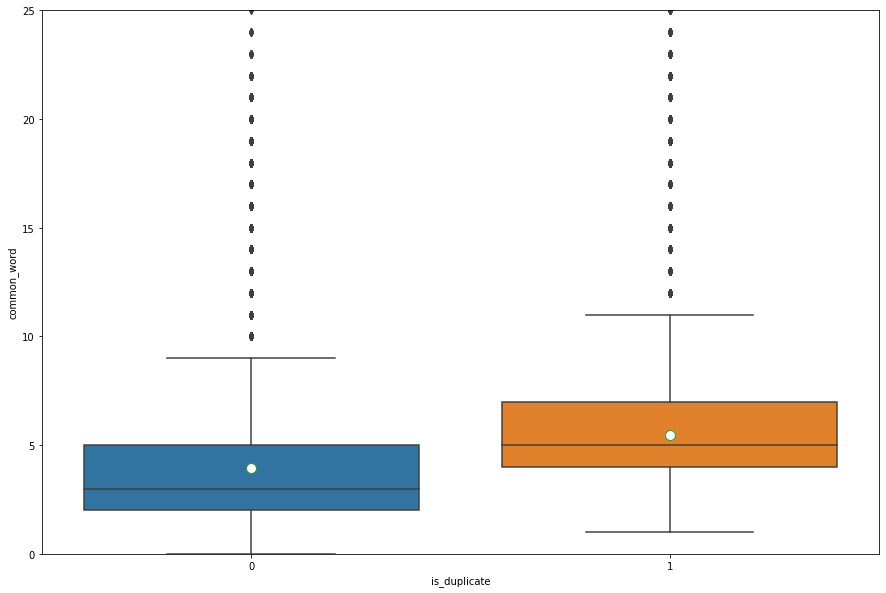

In [252]:
plt.figure(figsize=(15,10))
sns.boxplot(data=train, x='is_duplicate',y='common_word',
            showmeans=True,meanprops={"marker":"o",
                       "markerfacecolor":"white", "markersize":"10"})
plt.ylim(0,25)

In [254]:
train.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate', 'Q1',
       'Q2', 'num_char_1', 'num_char_2', 'total_char', 'num_words_1',
       'num_words_2', 'total_words', 'common_word', 'q1_frency', 'q2_frency',
       'frequency', 'dff_freq'],
      dtype='object')

In [258]:
# sns.pairplot(data=train[:5000], vars=['num_char_1', 'num_char_2', 'total_char', 'num_words_1',
#        'num_words_2', 'total_words', 'common_word', 'q1_frency', 'q2_frency',
#        'frequency', 'dff_freq'], hue='is_duplicate')

In [264]:
def plot_distribution(df, col):
    plt.figure(figsize=(20, 10))
  
    plt.subplot(1, 2, 1)
    sns.boxplot(x = 'is_duplicate', y = col, data = df)
    plt.title('Box Plot - {}'.format(col))
    plt.xlabel('Class label')
    plt.xticks([0,1],['Non-Duplicate','Duplicate'], rotation=0)
    plt.ylabel(col)
    
    plt.subplot(1, 2, 2)

    sns.distplot(df[df['is_duplicate']==0][col], hist=False, 
                 label='Non-Duplicate', color='blue', kde_kws={'shade': True})
    sns.distplot(df[df['is_duplicate']==1][col], hist=False, 
                 label='Duplicate', color='red', kde_kws={'shade': True})
    plt.title('PDF - {}'.format(col))
    plt.xlabel(col)
    plt.legend()

    plt.show()

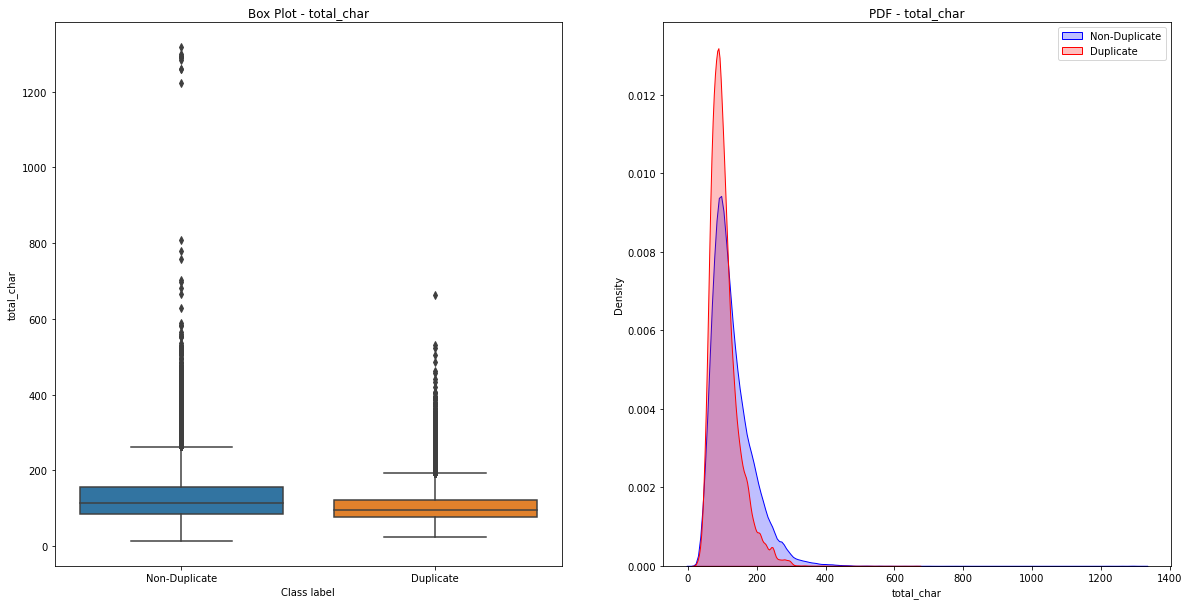

In [265]:
plot_distribution(train, 'total_char')

### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

#### CountVectorizer

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

In [114]:
#use CounteVectorizer to count the number of words(term frequency)

In [115]:
#instantiate CountVectorizer() 
cv=CountVectorizer() 
# this steps generates word counts for the words in your docs 
wc_vector=cv.fit(pd.concat((train['Q1'],train['Q2'])).unique())


In [116]:
wc_train_q1 = wc_vector.transform(train['Q1'].values)
wc_train_q2 = wc_vector.transform(train['Q2'].values)

In [117]:
X_train_wc=hstack((wc_train_q1,wc_train_q2))

In [123]:
wc_test_q1 =wc_vector.transform(test['Q1'].values)
wc_test_q2 =wc_vector.transform(test['Q2'].values)

In [124]:
X_test_wc=hstack((wc_test_q1,wc_test_q2))

#### tf-idf

In [44]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000,use_idf=True)

In [45]:
train.dropna(inplace=True)

In [127]:
tfidf_vect.fit(pd.concat((train['Q1'],train['Q2'])).unique())

TfidfVectorizer(max_features=5000, token_pattern='\\w{1,}')

In [131]:
train_q1_trans = tfidf_vect.transform(train['Q1'].values)
train_q2_trans = tfidf_vect.transform(train['Q2'].values)

In [132]:
train_vc=tfidf_vect.transform(train_question)

In [161]:
#analysie
v1=train_q1_trans[0]
v2=train_q2_trans[0]
v3=train_vc[1]

In [162]:
def create_doc_term_matrix(text,vectorizer):
    doc_term_matrix = vectorizer.fit_transform(text)
    return pd.DataFrame(doc_term_matrix.toarray(), columns = vectorizer.get_feature_names())


In [ ]:
x=pd.concat((train['Q1'],train['Q2'])).unique()
f=create_doc_term_matrix(x,TfidfVectorizer())
m2 = (f != 0).any()


In [ ]:
a=pd.DataFrame(v3.T.todense(), 
             index=tfidf_vect.get_feature_names(), 
             columns=["tfidf"]).sort_values(by=["tfidf"],ascending=False)


In [108]:
# a[a['tfidf']!=0]

In [106]:
# pd.DataFrame(v1.T.todense(), 
#              index=tfidf_vect.get_feature_names(), 
#              columns=["tfidf"]).sort_values(by=["tfidf"],ascending=False)


In [105]:
# pd.DataFrame(v2.T.todense(), 
#              index=tfidf_vect.get_feature_names(), 
#              columns=["tfidf"]).sort_values(by=["tfidf"],ascending=False)


In [133]:
labels=train['is_duplicate'].values

In [134]:
X_train =hstack((train_q1_trans,train_q2_trans))

In [135]:
#same for testing
test_q1_trans = tfidf_vect.transform(test['Q1'].values)
test_q2_trans = tfidf_vect.transform(test['Q2'].values)

In [136]:
X_test =hstack((test_q1_trans,test_q2_trans))
test_labels=test['is_duplicate'].values

#### word2vec

In [116]:
train=train.dropna()

In [137]:
test=test.dropna()

In [166]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder

In [118]:
import gensim

In [49]:
model = gensim.models.KeyedVectors.load_word2vec_format('/Users/oliviahan/Documents/GitHub/lighthouselabs_data_notes/Week_8/W8D3/GoogleNews-vectors-negative300.bin', binary=True)  

In [283]:
from pyemd import emd


In [280]:
distance = model.wmdistance(train['Q1'][0], train['Q2'][0])

In [281]:
distance

0.12911553671619816

In [286]:
d=[]
for index, row in train.iterrows():
    distance = model.wmdistance(row['Q1'], row['Q2'])
    d.append(distance)


In [287]:
train['distance']=d

In [233]:
from nltk import word_tokenize
def avg_sentence(sentence, wv):
    v = np.zeros(300)
    for w in sentence:
        if w in wv:
            v += wv[w]
    return v / len(sentence)

def cosine_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))



In [55]:
train['Q1'][0]

'astrology  i am a capricorn sun cap moon and cap rising   what does that say about me '

In [56]:
train['Q2'][0]

'i am a triple capricorn  sun  moon and ascendant in capricorn  what does this say about me '

In [60]:
vec1 = avg_sentence(train['Q1'][0],model)
vec2 = avg_sentence(train['Q2'][0],model)

In [61]:
cosine_sim(vec1,vec2)

0.9963263812469607

In [119]:
similar=[]
for index, row in train.iterrows():
    vec1=avg_sentence(row['Q1'],model)
    vec2=avg_sentence(row['Q2'],model)
    similar.append(cosine_sim(vec1,vec2))

In [120]:
train['cos_sim']=similar

In [121]:
train.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate', 'Q1',
       'Q2', 'q1_frency', 'q2_frency', 'frequency', 'dff_freq', 'num_char_1',
       'num_words_1', 'num_words_2', 'total_words', 'common_word',
       'num_char_2', 'total_char', 'cos_sim'],
      dtype='object')

In [211]:
train['word_dff']=abs(train['num_words_2']-train['num_words_1'])
test['word_dff']=abs(test['num_words_2']-test['num_words_1'])


In [290]:
# X_train=train[['q1_frency','q2_frency','frequency','dff_freq','num_char_1','num_char_2',
#         'total_words','common_word','total_char','cos_sim']]
X_train=train[['dff_freq','word_dff','num_char_1','num_char_2','num_words_1','num_words_2',
               'common_word','cos_sim','distance']]

In [123]:
y_train=train['is_duplicate']

In [124]:
#for test set

In [293]:
d=[]
for index, row in test.iterrows():
    distance = model.wmdistance(row['Q1'], row['Q2'])
    d.append(distance)

In [294]:
test['distance']=d

In [288]:
similar=[]
for index, row in test.iterrows():
    vec1=avg_sentence(row['Q1'],model)
    vec2=avg_sentence(row['Q2'],model)
    similar.append(cosine_sim(vec1,vec2))


In [289]:
test['cos_sim']=similar

In [185]:
train.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate', 'Q1',
       'Q2', 'q1_frency', 'q2_frency', 'frequency', 'dff_freq', 'num_char_1',
       'num_words_1', 'num_words_2', 'total_words', 'common_word',
       'num_char_2', 'total_char', 'cos_sim'],
      dtype='object')

In [295]:
# X_test=test[['q1_frency','q2_frency','frequency','dff_freq','num_char_1','num_char_2',
#         'total_words','common_word','total_char','cos_sim']]
X_test=test[[ 'dff_freq','word_dff','num_char_1','num_char_2',
             'num_words_1','num_words_2',
            'common_word','cos_sim','distance']]

In [140]:
y_test=test['is_duplicate']

In [296]:
s=StandardScaler()
scale=s.fit(X_train)

In [297]:
X_train_wv=scale.transform(X_train)
X_test_wv=scale.transform(X_test)

In [167]:
l=LabelEncoder()
y_train=l.fit_transform(y_train)
y_test=l.fit_transform(y_test)

### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

In [216]:
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

#### Logistic Regression

In [217]:
lr_model=LogisticRegression()

In [298]:
# lr_model.fit(X_train,labels)
lr_model.fit(X_train_wv,y_train)


LogisticRegression()

In [299]:
y_pred = lr_model.predict(X_test_wv)

In [182]:
#TFIDF
metrics.accuracy_score(labels,lr_model.predict(X_train))


NameError: name 'labels' is not defined

In [142]:
metrics.accuracy_score(test_labels,y_pred)

0.7350975630181726

In [300]:
#word2vec
metrics.accuracy_score(y_train,lr_model.predict(X_train_wv))


0.7100749549851346

In [301]:
metrics.accuracy_score(y_test,y_pred)

0.6821012897137465

In [160]:
print('training score:', metrics.f1_score(labels, lr_model.predict(X_train), average='macro'))
print('validation score:', metrics.f1_score(test_labels, y_pred, average='macro'))
print(metrics.classification_report(test_labels,y_pred))

training score: 0.738252834110742
validation score: 0.7350743395949917
              precision    recall  f1-score   support

           0       0.73      0.74      0.74     29839
           1       0.74      0.73      0.73     29866

    accuracy                           0.74     59705
   macro avg       0.74      0.74      0.74     59705
weighted avg       0.74      0.74      0.74     59705



In [302]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.68      0.70      0.69     23908
           1       0.69      0.66      0.68     23777

    accuracy                           0.68     47685
   macro avg       0.68      0.68      0.68     47685
weighted avg       0.68      0.68      0.68     47685



In [303]:
xgb_model = xgb.XGBClassifier(max_depth=50, 
                              n_estimators=80, 
                              learning_rate=0.1, 
                              colsample_bytree=.7, 
                              gamma=0, 
                              reg_alpha=4, 
                              objective='binary:logistic', 
                              eta=0.3, silent=1, 
                              subsample=0.8) 
# pipeline = Pipeline([
#     ('vectorizer', TfidfVectorizer()),
#     ('classifier', xgb_model)
# ])
# pipeline.fit(X_train, labels)


In [304]:
xgb_model.fit(X_train_wv,y_train)

[12:22:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:22:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              enable_categorical=False, eta=0.3, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=50,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=80, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=4, reg_lambda=1, scale_pos_weight=1,
              silent=1, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [305]:

label_prediction = xgb_model.predict(X_test_wv)

In [151]:
#tfidfb
metrics.accuracy_score(label_prediction,test_labels)

0.8791558495938364

In [306]:
#word2vec
metrics.accuracy_score(label_prediction,y_test)

0.8502883506343714

In [307]:
print('training score:', metrics.f1_score(labels, xgb_model.predict(X_train), average='macro'))
print('validation score:', metrics.f1_score(y_test, label_prediction, average='macro'))
print(metrics.classification_report(y_test,label_prediction))

NameError: name 'labels' is not defined

In [308]:
#word2vec
print('training score:', metrics.f1_score(y_train, xgb_model.predict(X_train_wv), average='macro'))
print('validation score:', metrics.f1_score(y_pred, label_prediction, average='macro'))
print(metrics.classification_report(label_prediction,y_pred))

training score: 0.8810075247121725
validation score: 0.776124592213647
              precision    recall  f1-score   support

           0       0.78      0.79      0.78     24525
           1       0.77      0.77      0.77     23160

    accuracy                           0.78     47685
   macro avg       0.78      0.78      0.78     47685
weighted avg       0.78      0.78      0.78     47685



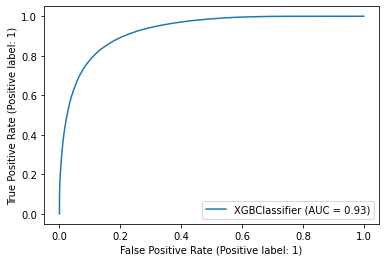

In [274]:
metrics.plot_roc_curve(xgb_model,X_train_wv,y_train)

In [154]:
metrics.recall_score(test_labels,label_prediction)

0.8856559298198621

In [134]:
# #hyper parameter
# params={
#     'max_depth': [30,50,100],
#     'n_estimators':[40,50,80],
#     'learning_rate':[0.05,0.1,0.2],
#     'gamma':[3,4,5]

# }

In [137]:
# grid=GridSearchCV(estimator=xgb.XGBClassifier(use_label_encoder=False),
#                  param_grid=params,
#                  scoring='roc_auc',
#                  cv=3,
#                  )

In [139]:
# grid.fit(X_train,labels)

In [140]:
# grid.best_estimator_

<238819x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 4565634 stored elements in Compressed Sparse Row format>

#### LSTM with word2vec


In [146]:
np.random.seed(1337)
from keras.models import Sequential, Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Input, Flatten, merge, LSTM, Lambda, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.layers.normalization import BatchNormalization
from keras import backend as K

In [150]:
max_token=1000
max_length=100

model_1.add(Embedding(max_token, 32))
model_1.add(Dropout(0.3))

model_1.add(LSTM(32))

model_1.add(Dropout(0.3))
model_1.add(Dense(1, activation = 'sigmoid'))
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [151]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          32000     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 40,353
Trainable params: 40,353
Non-trainable params: 0
_________________________________________________________________


In [160]:
model_1.fit(X_train_wc, labels, epochs = 5, batch_size=128)

Epoch 1/5


TypeError: in user code:

    /Users/oliviahan/opt/anaconda3/envs/venv/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /Users/oliviahan/opt/anaconda3/envs/venv/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/oliviahan/opt/anaconda3/envs/venv/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/oliviahan/opt/anaconda3/envs/venv/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/oliviahan/opt/anaconda3/envs/venv/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/oliviahan/opt/anaconda3/envs/venv/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /Users/oliviahan/opt/anaconda3/envs/venv/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /Users/oliviahan/opt/anaconda3/envs/venv/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/oliviahan/opt/anaconda3/envs/venv/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:375 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /Users/oliviahan/opt/anaconda3/envs/venv/lib/python3.9/site-packages/tensorflow/python/keras/engine/functional.py:424 call
        return self._run_internal_graph(
    /Users/oliviahan/opt/anaconda3/envs/venv/lib/python3.9/site-packages/tensorflow/python/keras/engine/functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /Users/oliviahan/opt/anaconda3/envs/venv/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/oliviahan/opt/anaconda3/envs/venv/lib/python3.9/site-packages/tensorflow/python/keras/layers/embeddings.py:196 call
        out = embedding_ops.embedding_lookup_v2(self.embeddings, inputs)
    /Users/oliviahan/opt/anaconda3/envs/venv/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/oliviahan/opt/anaconda3/envs/venv/lib/python3.9/site-packages/tensorflow/python/ops/embedding_ops.py:394 embedding_lookup_v2
        return embedding_lookup(params, ids, "div", name, max_norm=max_norm)
    /Users/oliviahan/opt/anaconda3/envs/venv/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/oliviahan/opt/anaconda3/envs/venv/lib/python3.9/site-packages/tensorflow/python/ops/embedding_ops.py:322 embedding_lookup
        return _embedding_lookup_and_transform(
    /Users/oliviahan/opt/anaconda3/envs/venv/lib/python3.9/site-packages/tensorflow/python/ops/embedding_ops.py:134 _embedding_lookup_and_transform
        ids = ops.convert_to_tensor(ids, name="ids")
    /Users/oliviahan/opt/anaconda3/envs/venv/lib/python3.9/site-packages/tensorflow/python/profiler/trace.py:163 wrapped
        return func(*args, **kwargs)
    /Users/oliviahan/opt/anaconda3/envs/venv/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:1540 convert_to_tensor
        ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
    /Users/oliviahan/opt/anaconda3/envs/venv/lib/python3.9/site-packages/tensorflow/python/framework/constant_op.py:339 _constant_tensor_conversion_function
        return constant(v, dtype=dtype, name=name)
    /Users/oliviahan/opt/anaconda3/envs/venv/lib/python3.9/site-packages/tensorflow/python/framework/constant_op.py:264 constant
        return _constant_impl(value, dtype, shape, name, verify_shape=False,
    /Users/oliviahan/opt/anaconda3/envs/venv/lib/python3.9/site-packages/tensorflow/python/framework/constant_op.py:281 _constant_impl
        tensor_util.make_tensor_proto(
    /Users/oliviahan/opt/anaconda3/envs/venv/lib/python3.9/site-packages/tensorflow/python/framework/tensor_util.py:551 make_tensor_proto
        raise TypeError("Failed to convert object of type %s to Tensor. "

    TypeError: Failed to convert object of type <class 'tensorflow.python.framework.sparse_tensor.SparseTensor'> to Tensor. Contents: SparseTensor(indices=Tensor("DeserializeSparse:0", shape=(None, 2), dtype=int64), values=Tensor("sequential_1/embedding_1/Cast:0", shape=(None,), dtype=int32), dense_shape=Tensor("stack:0", shape=(2,), dtype=int64)). Consider casting elements to a supported type.


In [163]:
from tensorflow.keras import layers

input_dim = X_train_wc.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                1268770   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 1,268,781
Trainable params: 1,268,781
Non-trainable params: 0
_________________________________________________________________


In [165]:
history = model.fit(X_train_wc, labels,
                    epochs=100,
                    verbose=False,
                    validation_data=(X_test_wc, test_labels),
                    batch_size=10)

2022-07-28 22:41:49.168750: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


KeyboardInterrupt: 